In [1]:
import os
import Augmentor
import zipfile
import random
import zipfile
import pathlib
import pydot
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile

In [ ]:
local_zip = 'Discoloration.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('Dataset/')
zip_ref.close()

local_zip2 = 'Periodontal.zip'
zip_ref2    = zipfile.ZipFile(local_zip2, 'r')
zip_ref2.extractall('Dataset/') 
zip_ref2.close()

In [ ]:
print(len(os.listdir('Dataset/Dental Discoloration')))
print(len(os.listdir('Dataset/Periodontal')))

In [2]:
def AugmentData(source_dir, count):
    source_dir = source_dir
    output_dir = "."
    p = Augmentor.Pipeline(source_directory=source_dir, output_directory=output_dir)
    #p.random_distortion(probability=1, grid_width=4, grid_height=4, magnitude=1)
    p.rotate(probability=0.001, max_left_rotation=0.001, max_right_rotation=0.001)
    #p.zoom_random(probability=0.5, percentage_area=0.9)
    #p.crop_random(probability=0.6, percentage_area=0.9)
    #p.resize(probability=1.0, width=64, height=64)
    p.sample(count)

In [5]:
AugmentData("dataset2/Dental Discoloration/", 1000)
AugmentData("dataset2/Periodontal/", 1000)
AugmentData("dataset2/Healthy/", 1000)

Initialised with 29 image(s) found.
Output directory set to dataset2/Dental Discoloration/..

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=650x433 at 0x25DC3B1C250>: 100%|█| 1000/1000 [00:03<0


Initialised with 15 image(s) found.
Output directory set to dataset2/Periodontal/..

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x197 at 0x25DC3A123D0>: 100%|█| 1000/1000 [00:02<0


Initialised with 90 image(s) found.
Output directory set to dataset2/Healthy/..

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=612x408 at 0x25DC39F0880>: 100%|█| 1000/1000 [00:03<0


In [6]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[:testing_length]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)


Discoloration_SOURCE_DIR = "dataset2/Dental Discoloration/"
Periodontal_SOURCE_DIR = "dataset2/Periodontal/"
Healthy_SOURCE_DIR = "dataset2/Healthy/"

TRAINING_Discoloration_DIR = "dataolah/training/Dental Discoloration/"
TRAINING_Periodontal_DIR = "dataolah/training/Periodontal/"
TRAINING_Healthy_DIR = "dataolah/training/Healthy/"

TESTING_Discoloration_DIR = "dataolah/testing/Dental Discoloration/"
TESTING_Periodontal_DIR = "dataolah/testing/Periodontal/"
TESTING_Healthy_DIR = "dataolah/testing/Healthy/"
split_size = .8
split_data(Discoloration_SOURCE_DIR, TRAINING_Discoloration_DIR, TESTING_Discoloration_DIR, split_size)
split_data(Periodontal_SOURCE_DIR, TRAINING_Periodontal_DIR, TESTING_Periodontal_DIR, split_size)
split_data(Healthy_SOURCE_DIR, TRAINING_Healthy_DIR, TESTING_Healthy_DIR, split_size)

In [7]:
TRAINING_DIR = "dataolah/training/"
# Experiment with your own parameters here to really try to drive it to 99.9% accuracy or better
train_datagen = ImageDataGenerator(rescale=1./255,
      rotation_range=50,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.1,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=20,
                                                    class_mode='categorical',
                                                    target_size=(150, 150))

VALIDATION_DIR = "dataolah/testing/"
# Experiment with your own parameters here to really try to drive it to 99.9% accuracy or better
validation_datagen = ImageDataGenerator(rescale=1./255,
      rotation_range=50,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.1,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=10,
                                                              class_mode='categorical',
                                                              target_size=(150, 150))

# Expected Output:
# Found 22498 images belonging to 2 classes.
# Found 2500 images belonging to 2 classes.

Found 2507 images belonging to 3 classes.
Found 627 images belonging to 3 classes.


In [8]:
class_names =  ["Discloration", "Healthy", "Periodontal"]
for i in range(len(class_names)):
    print(class_names[i] ," " , i)

Discloration   0
Healthy   1
Periodontal   2


In [9]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Dropout(0.2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 17, 17, 128)       0

In [10]:
# Set the training parameters
model.compile(loss = 'categorical_crossentropy', 
              optimizer=Adam(learning_rate=0.0001), 
              metrics=['accuracy'])

In [11]:
history = model.fit(train_generator,
                    steps_per_epoch=32,
                    epochs=15,
                    validation_data=validation_generator,
                    validation_steps=10,
                    verbose=1)

Epoch 1/15
32/32 [==============================] - 23s 732ms/step - loss: 1.1057 - accuracy: 0.3234 - val_loss: 1.0808 - val_accuracy: 0.3300
Epoch 2/15
32/32 [==============================] - 33s 1s/step - loss: 1.0755 - accuracy: 0.3656 - val_loss: 1.0499 - val_accuracy: 0.5100
Epoch 3/15
32/32 [==============================] - 34s 1s/step - loss: 1.0394 - accuracy: 0.4609 - val_loss: 0.9532 - val_accuracy: 0.5100
Epoch 4/15
32/32 [==============================] - 33s 1s/step - loss: 1.0024 - accuracy: 0.4992 - val_loss: 0.9983 - val_accuracy: 0.4700
Epoch 5/15
32/32 [==============================] - 33s 1s/step - loss: 0.8910 - accuracy: 0.5901 - val_loss: 0.8652 - val_accuracy: 0.5200
Epoch 6/15
32/32 [==============================] - 33s 1s/step - loss: 0.8248 - accuracy: 0.5750 - val_loss: 0.7984 - val_accuracy: 0.5900
Epoch 7/15
32/32 [==============================] - 28s 877ms/step - loss: 0.7243 - accuracy: 0.6781 - val_loss: 0.7341 - val_accuracy: 0.6300
Epoch 8/15
32/

In [12]:
model.evaluate(validation_generator)

63/63 [==============================] - 7s 110ms/step - loss: 0.4209 - accuracy: 0.8198


[0.42094385623931885, 0.819776713848114]

<Figure size 432x288 with 0 Axes>

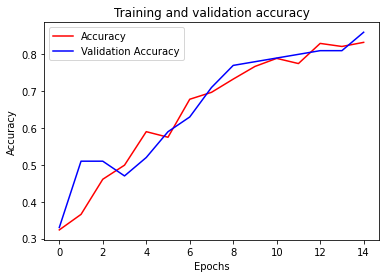

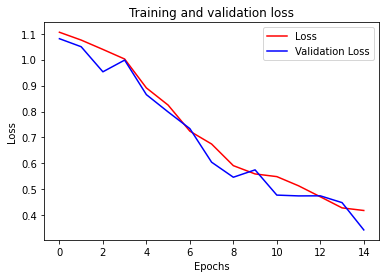

<Figure size 432x288 with 0 Axes>

In [13]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()


# Expected Output
# A chart where the validation loss does not increase sharply!

prediksi: Periodontal
persentase prediksi: 76.10 %


prediksi:	Discloration
persentase:	22.21 %
prediksi:	Healthy
persentase:	1.68 %
prediksi:	Periodontal
persentase:	76.10 %


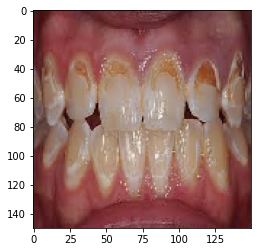

In [21]:
from tensorflow.keras.preprocessing import image
import numpy as np

image_path = "cc.jpg"
new_img = image.load_img(image_path, target_size=(150, 150))
img = image.img_to_array(new_img)/255
img = np.expand_dims(img, axis=0)

images = np.vstack([img])

prediction = model.predict(images, batch_size=10)
predictions = np.argmax(prediction,axis=1)

print('prediksi: {}'.format(class_names[predictions[0]]))
print('persentase prediksi: {:.2f} %'.format(np.max(prediction)*100))
print('\n')
for i in range(len(class_names)):
    print('prediksi:\t{}'. format(class_names[i]))
    print("persentase:\t{:.2f} %".format(prediction[0][i]*100))

plt.imshow(new_img)

In [15]:
export_dir = 'saved_model/2/'
tf.saved_model.save(model, export_dir)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: saved_model/2/assets


In [18]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

In [22]:
tflite_model_file = pathlib.Path('./model1.tflite')
tflite_model_file.write_bytes(tflite_model)

38868648